# Importing Libraries

In [1]:
import os
import socket
import time
import numpy as np
import tensorflow as tf
from datetime import datetime
import matplotlib.pyplot as plt
import cv2
import sklearn.preprocessing as skp
import tflib


import module 
import preprocessing
import metrics

tf.keras.backend.set_floatx('float64')
tf.autograph.set_verbosity(0)

@tf.function
def sample_P2E(P, model):
    fake_ecg = model(P, training=False)
    return fake_ecg

## Configuring CUDA Devices

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1,2"

# Loading the Model
The model is loaded and the sampling frequency is set to 128 Hz, with a window size of 4s

In [13]:
ecg_sampling_freq = 128
ppg_sampling_freq = 128
window_size = 4
ecg_segment_size = ecg_sampling_freq*window_size
ppg_segment_size = ppg_sampling_freq*window_size
model_dir = 'weights/weights'

""" model """
Gen_PPG2ECG = module.generator_attention()
""" resotre """
tflib.Checkpoint(dict(Gen_PPG2ECG=Gen_PPG2ECG), model_dir).restore()
print("model loaded successfully")

model loaded successfully


Pointing to the dataset

In [4]:
dataset = "datasets/physionet.org/files/bidmc/1.0.0/bidmc_csv/bidmc_02_Signals.csv"

# Data Preprocessing
Here, we use an example from the BIDMC dataset to evaluate the model <br>
The data is loaded, and the excess leads containing ECG data is trimmed away (Lead II is used here)

In [5]:
import dataset_preprocessing as dp

ppg, ecg = dp.read_from_csv(dataset, 'BIDMC')

# Inference
Data is first resized to 128Hz sampling freq over a 4 sec window <br>
It is then passed through a Band-Pass Butterworth Filter with a Pass-Band Freq of 1Hz and Stop-Band Freq of 8Hz <br>
Min-max normalisation is applied to the data

In [6]:
# load the data:  
x_ppg = ppg[4000:4500]
# resample to 128 Hz using: 
x_ppg = cv2.resize(x_ppg, (1,ppg_segment_size), interpolation = cv2.INTER_LINEAR)
# print(x_ppg.shape)
x_ppg = x_ppg.reshape(1, -1)
# filter the data using: 
x_ppg = preprocessing.filter_ppg(x_ppg, 128)

# make an array to N x 512 [this is the input shape of x_ppg], where Nx512=len(x_ppg)
# normalize the data b/w -1 to 1: 
x_ppg = skp.minmax_scale(x_ppg, (-1, 1), axis=1)
# print(x_ppg)
#######
#
x_ecg = sample_P2E(x_ppg, Gen_PPG2ECG)
x_ecg = x_ecg.numpy()
x_ecg = preprocessing.filter_ecg(x_ecg, 128)


2022-09-11 11:13:22.712831: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7


Plotting the results, we get

In [7]:
ecg = skp.minmax_scale(ecg, (-1, 1), axis=0)

(500,)


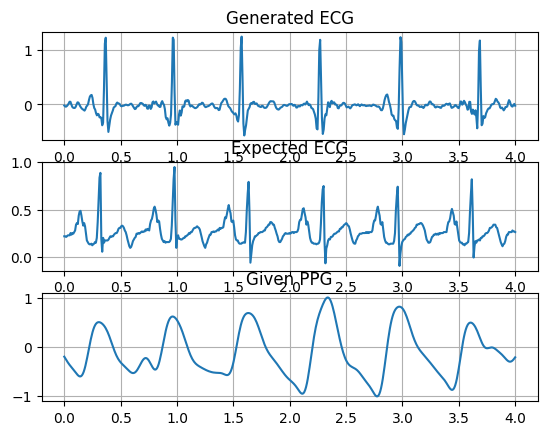

In [8]:
figure, axis = plt.subplots(3, 1)
x_gen = np.linspace(0,4,512)
x_dataset = np.linspace(0,4,500)
  
# For Sine Function
axis[0].plot(x_gen,x_ecg[0,:])
axis[0].set_title("Generated ECG")
plt.grid()
  
# For Cosine Function
print(ecg[:500].shape)
axis[1].plot(x_dataset,ecg[4000:4500] )
axis[1].set_title("Expected ECG")
plt.grid()

axis[2].plot(x_gen,x_ppg[0,:] )
axis[2].set_title("Given PPG")
axis[2].grid()
axis[1].grid()
axis[0].grid()

(500,)


Text(0.5, 1.0, 'Expected')

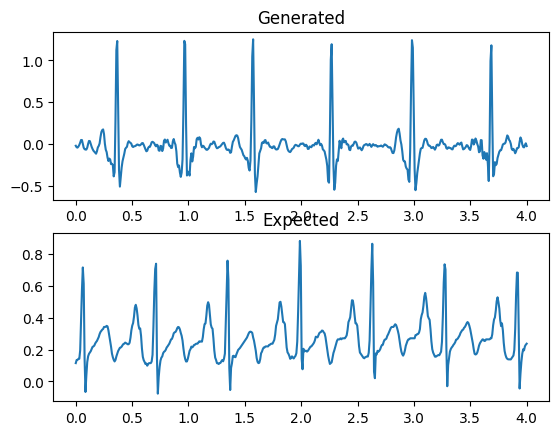

In [9]:
ecg_resampled = cv2.resize(ecg[:500], (1,ppg_segment_size), interpolation = cv2.INTER_LINEAR)
figure, axis = plt.subplots(2, 1)
x_gen = np.linspace(0,4,512)
x_dataset = np.linspace(0,4,500)
  
# For Sine Function
axis[0].plot(x_gen,x_ecg[0,:])
axis[0].set_title("Generated")
  
# For Cosine Function
print(ecg[:500].shape)
axis[1].plot(x_gen,ecg_resampled )
axis[1].set_title("Expected")

# Metrics

In [10]:
import glob
import tqdm

In [11]:
path = "datasets/physionet.org/files/bidmc/1.0.0/bidmc_csv"
file_list = glob.glob(f'{path}/*Signals.csv')
# print(file_list)
x_mse = 0
x_prd = 0

for i in tqdm.tqdm(file_list):
    mse,prd = metrics.read_file_and_estimate(f'{i}',Gen_PPG2ECG)
    x_mse += mse
    x_prd += prd
x_mse = x_mse/53
x_prd = x_prd/53
# print(x)

100%|███████████████████████████████████████████| 53/53 [05:34<00:00,  6.31s/it]


NameError: name 'x' is not defined

In [12]:
print(x_mse)
print(x_prd)

0.2916829786946361
473462887435.1811
